In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os, json

In [2]:
DATAPATH = '../datasets/isrl_kaggle/'
data_files = os.listdir(DATAPATH)
print(f'List of files in dataset: {data_files}')
with open(DATAPATH + data_files[1]) as f:
    signs_index_map = json.load(f)
data_df = pd.read_csv(DATAPATH + data_files[2])
data_df['sign_value'] = data_df.sign.map(signs_index_map)
data_df.head(5)

List of files in dataset: ['train_landmark_files', 'sign_to_prediction_index_map.json', 'train.csv']


,path,participant_id,sequence_id,sign,sign_value
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


In [3]:
eda = pd.DataFrame(columns=['nframes', 'nanface', 'nanleft', 'nanpose', 'nanright'])
for parquet_file in data_df.path:
    df = pd.read_parquet(DATAPATH + parquet_file)
    nframes = df.frame.unique().size
    df = df.groupby(['frame','type']).count()
    frames_with_nan = (df.x.eq(0)).astype(int)
    frames_with_nan = frames_with_nan.reset_index(level=1).groupby('type').sum().x.to_list()
    eda.loc[len(eda)] = [nframes, *frames_with_nan]
eda['sign_value'] = data_df.sign.map(signs_index_map)
eda.head()

,nframes,nanface,nanleft,nanpose,nanright,sign_value
0,23,0,23,0,12,25
1,11,0,11,0,9,232
2,105,0,77,0,105,48
3,12,0,12,0,0,23
4,18,0,18,0,0,164


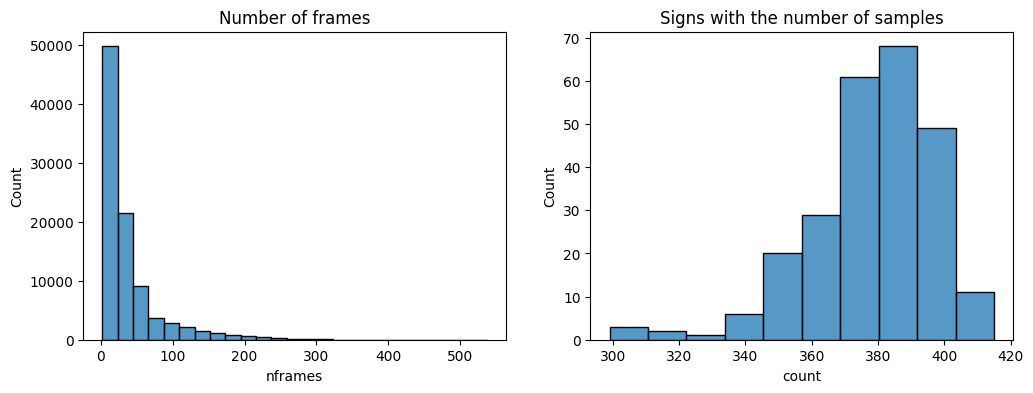

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=eda, x='nframes', bins=25, ax=axes[0])
axes[0].title.set_text('Number of frames')
sns.histplot(data=eda.sign_value.value_counts(),bins=10, ax=axes[1])
axes[1].title.set_text('Signs with the number of samples')

In [6]:
print('Percentage of videos without a landmark:')
100 * (len(eda) - eda[['nanface', 'nanleft', 'nanpose', 'nanright']].eq(0).sum()) / len(eda)

Percentage of videos without a landmark:


nanface      4.695323
nanleft     92.665940
nanpose      0.000000
nanright    87.878531
dtype: float64